In [2]:
import os

import mne

import re

import numpy as np
import pandas as pd
import scipy as sp

from bids import BIDSLayout

from itertools import combinations, product

from crosspy.preprocessing.seeg.seeg_utils import group_by_reference
import matplotlib.pyplot as plt

import nibabel as nib
from IPython.display import Image

from collections import defaultdict

In [3]:
# import surfer
# from surfer import Brain, utils

# from mayavi import mlab
# mlab.init_notebook()

In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
# rcParams['font.sans-serif'] = ['Tahoma']

In [5]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)

In [6]:
def create_reference_mask(ch_names):
    n_chans = len(ch_names)
    mask = np.ones((n_chans, n_chans))

    grouped = group_by_reference(ch_names)

    for _, nodes in grouped.items():
        for i, j in combinations(nodes, 2):
            mask[i, j] = mask[j, i] = 0
    
    mask[np.diag_indices_from(mask)] = 0
    
    return mask

In [7]:
with open('Yeo_7Network_order_LUT.txt') as fin:
    yeo_names = [line.split()[1] for line in fin.readlines()]

In [8]:
subject_to_cluster = pd.read_csv('Subject_agg_cluster_labels.csv').set_index('subject_number')

ez_data = pd.read_csv('202001_SEEG_ripple_Cohort_Contacts.csv', sep=';', header=None)
ez_grouped = ez_data.groupby(0)

df = pd.read_csv('../seeg_phases/data/SEEG_redux_BIDS/convert_results.csv')
df_num_idx = df.set_index('subject_number')

In [28]:
root_path = os.path.join('../seeg_phases/data', 'SEEG_redux_BIDS')
layout = BIDSLayout(root_path)

fig_d_data = np.zeros(shape=(105,105))
fig_d_data_original = np.zeros(shape=(105,105))

all_indicies = set()

max_mop = -1
min_mop = 200

for subject in layout.get(target='subject', extension='edf'): 
    subj_num = int(subject.entities['subject'])
    
    if subj_num in {36, 57}:
        continue
    
    subj_name = df_num_idx.loc[subj_num]['name']
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    data_fname = subject.filename
    
    montage_filename = os.path.join(subject.dirname,  'sub-{}_montage.tcsv'.format(subject.entities['subject']))
    parc_filename = os.path.join(subject.dirname, 'sub-{}_par-yeo7_mOp.npy'.format(subject.entities['subject']))
    
    if not(os.path.exists(montage_filename)):
        print('Cannot find data for subject {}'.format(subject.entities['subject']))
        continue
        
    montage = pd.read_csv(montage_filename, sep='\t')
    mop = np.load(parc_filename)
        
    max_mop = max(max_mop, mop.max())
    min_mop = min(min_mop, mop.min())
    
    ch_names = montage['name'].values
    ref_mask = create_reference_mask(ch_names)
    ez_mask = [subj_ez.loc[ch_names[i]][2] != 0 for i in range(len(ch_names))]
    
    for i in range(mop.shape[0]):
        for j in range(i+1, mop.shape[0]):
            if ref_mask[i,j] == 0 or ez_mask[i] or ez_mask[j]:
                continue
                                
            l,r = mop[i,j]
            

            fig_d_data_original[l,r] += 1
            fig_d_data_original[r,l] += 1
                
    if subject_to_cluster.loc[subj_num]['subject_cluster'] == 4:
        continue
        
    for i in range(mop.shape[0]):
        for j in range(i+1, mop.shape[0]):   
            if ref_mask[i,j] == 0 or ez_mask[i] or ez_mask[j]:
                continue
            
            l,r = mop[i,j]
            
            fig_d_data[l,r] += 1
            fig_d_data[r,l] += 1

In [29]:
fig_d_data_original_yeo = fig_d_data_original[91:98, 91:98] + fig_d_data_original[98:105, 98:105]
fig_d_data_yeo = fig_d_data[91:98, 91:98] + fig_d_data[98:105, 98:105]

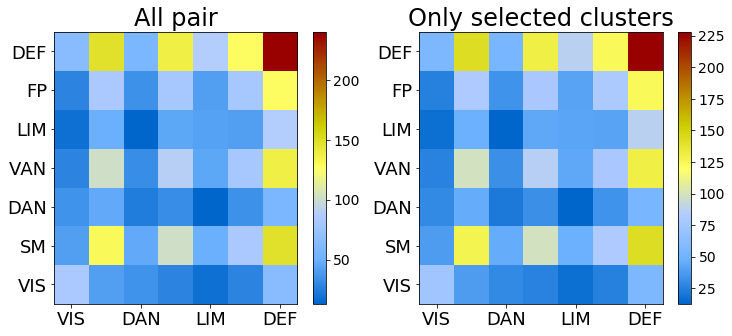

In [30]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2)

yeo_ticks = ['VIS', 'SM', 'DAN', 'VAN', 'LIM', 'FP', 'DEF']

imh1 = axes[0].imshow(fig_d_data_original_yeo / 100, origin='lower', cmap=ripples_cmap, aspect='auto')
imh2 = axes[1].imshow(fig_d_data_yeo / 100, origin='lower', cmap=ripples_cmap, aspect='auto')

axes[0].set_title('All pair', fontsize=24)
axes[1].set_title('Only selected clusters', fontsize=24)

for ax in axes:
    ax.set_yticks(np.arange(0,7))
    ax.set_yticklabels(yeo_ticks)
    ax.set_xticks(np.arange(0,7)[::2])
    ax.set_xticklabels(yeo_ticks[::2])
    ax.tick_params(labelsize=18)

cbar1 = fig.colorbar(imh1, ax=axes[0])
cbar2 = fig.colorbar(imh2, ax=axes[1])

cbar1.ax.tick_params(labelsize=14)
cbar2.ax.tick_params(labelsize=14)

fig.savefig('fig_1_d.svg', dpi=300)
fig.savefig('fig_1_d.pdf', dpi=300)

In [35]:
with open('Schaefer2018_100Parcels_7Networks_order_LUT.txt') as fin:
    schaefer_100_names = [line.split()[1] for line in fin.readlines()]

In [36]:
root_path = os.path.join('../seeg_phases/data', 'SEEG_redux_BIDS')
layout = BIDSLayout(root_path)

coverage = np.zeros((192,192))

mop_min = 1000
mop_max = -1

for subject in layout.get(target='subject', extension='edf'): 
    subj_num = int(subject.entities['subject'])
    
    if subj_num in {36, 57}:
        continue
    
    subj_name = df_num_idx.loc[subj_num]['name']
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    data_fname = subject.filename
    
    montage_filename = os.path.join(subject.dirname,  'sub-{}_montage.tcsv'.format(subject.entities['subject']))
    parc_filename = os.path.join(subject.dirname, 'sub-{}_par-parc2018yeo7_100_mOp.npy'.format(subject.entities['subject']))
        
    if not(os.path.exists(montage_filename)):
        print('Cannot find data for subject {}'.format(subject.entities['subject']))
        continue
        
    montage = pd.read_csv(montage_filename, sep='\t')
    mop = np.load(parc_filename)
    
    mop_max = max(mop.max(), mop_max)
    mop_min = min(mop.min(), mop_min)
    
    ch_names = montage['name'].values
    ref_mask = create_reference_mask(ch_names)
    ez_mask = [subj_ez.loc[ch_names[i]][2] != 0 for i in range(len(ch_names))]
                
    if subject_to_cluster.loc[subj_num]['subject_cluster'] == 4:
        continue
        
    for i in range(mop.shape[0]):
        for j in range(mop.shape[0]):   
            if ref_mask[i,j] == 0 or ez_mask[i] or ez_mask[j]:
                continue            
            
            l,r = mop[i,j]
            l, r = min(l,r), max(l,r)
            if l >= 91 and r >= 91:
                coverage[l,r] += 1

In [37]:
# lh_coverage = coverage[92:142, 92:142]
# rh_coverage = coverage[143:, 143:]
# inter_coverage = coverage[92:142, 143:] + coverage[143:, 92:142]

# n_total = 10000

# lh_stats = np.zeros(n_total)
# rh_stats = np.zeros(n_total)
# inter_stats = np.zeros(n_total)

# for i in range(n_total):
#     lh_stats[i] = np.sum(lh_coverage >= (i+1)) / (50**2)
#     rh_stats[i] = np.sum(rh_coverage >= (i+1)) / (50**2)
#     inter_stats[i] = np.sum(inter_coverage >= (i+1)) / (50**2)

In [38]:
lh_coverage = coverage[91:141, 91:141]
rh_coverage = coverage[142:, 142:]
inter_coverage = coverage[91:141, 142:] + coverage[142:, 91:141]

lh_coverage = lh_coverage[np.triu_indices_from(lh_coverage)]
rh_coverage = rh_coverage[np.triu_indices_from(rh_coverage)]
inter_coverage = inter_coverage[np.triu_indices_from(inter_coverage)]


n_total = 1000*2
n_ideal = np.triu(np.ones((50,50))).sum()

lh_stats = np.zeros(n_total)
rh_stats = np.zeros(n_total)
inter_stats = np.zeros(n_total)

for i in range(n_total):
    lh_stats[i] = np.sum(lh_coverage >= (i+1)) / n_ideal
    rh_stats[i] = np.sum(rh_coverage >= (i+1)) / n_ideal
    inter_stats[i] = np.sum(inter_coverage >= (i+1)) / n_ideal

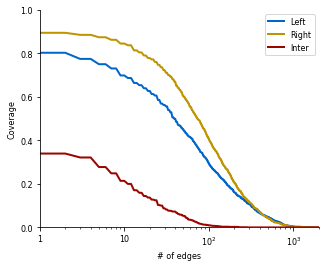

In [39]:
fig, ax = plt.subplots(figsize=(5, 4))
                       
ax.semilogx(np.arange(1, n_total+1), lh_stats, label='Left', color=ripples_cmap(0), lw=2)
ax.semilogx(np.arange(1,n_total+1), rh_stats, label='Right', color=ripples_cmap(0.75), lw=2)
ax.semilogx(np.arange(1,n_total+1), inter_stats, label='Inter', color=ripples_cmap(0.99), lw=2)

ax.set_xlim([1,n_total])
ax.set_ylim([0,1])

ax.set_xticks([1, 10, 100, 1000])
ax.set_xticklabels(['1', '10', r'$10^2$', r'$10^3$'])

ax.set_xlabel('# of edges', fontsize=8)
ax.set_ylabel('Coverage', fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=8)
ax.legend(fontsize=8)


fig.savefig('fig_1_c.svg')
fig.savefig('fig_1_c.pdf')

In [43]:
real_sub = '05'
subject_id = "sub-{}".format(real_sub)

subjects_dir = '../seeg_phases/data/SEEG_redux_BIDS/derivatives/'
aparc_file = os.path.join(subjects_dir,
                          subject_id, "label",
                          'lh' + ".parc2018yeo7_100.annot")
labels_lh, ctab_lh, names_lh = nib.freesurfer.read_annot(aparc_file)


aparc_file = os.path.join(subjects_dir,
                          subject_id, "label",
                          'rh' + ".parc2018yeo7_100.annot")
labels_rh, ctab_rh, names_rh = nib.freesurfer.read_annot(aparc_file)

names_lh = [n.decode() for n in names_lh]
names_rh = [n.decode() for n in names_rh]

coverage_dict_orig = defaultdict(int)
coverage_dict = defaultdict(int)

for subject in layout.get(target='subject', extension='edf'): 
    subj_num = int(subject.entities['subject'])
    subj_name = df_num_idx.loc[subj_num]['name']
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    if subj_num in {36, 57}:
        continue
    
    montage_filename = os.path.join(subject.dirname,  'sub-{}_montage.tcsv'.format(subject.entities['subject']))
    parc_filename = os.path.join(subject.dirname, 'sub-{}_par-parc2018yeo7_100_mOp.npy'.format(subject.entities['subject']))
        
    if not(os.path.exists(montage_filename)):
        print('Cannot find data for subject {}'.format(subject.entities['subject']))
        continue
        
    montage = pd.read_csv(montage_filename, sep='\t')
    mop = np.load(parc_filename)
    
    ref_mask = create_reference_mask(montage['name'].values)
    ch_names = montage['name'].values
    
    for i in range(mop.shape[0]):
        if subj_ez.loc[ch_names[i]][2] != 0:
            continue
        
        parcel_mop_idx = mop[i,i,0]

        if parcel_mop_idx < 92:
            continue

        parc_name = schaefer_100_names[parcel_mop_idx]        
        coverage_dict_orig[parc_name] += 1

    if subject_to_cluster.loc[subj_num]['subject_cluster'] == 4:
        continue
        
    for i in range(mop.shape[0]):
        if subj_ez.loc[ch_names[i]][2] != 0:
            continue
        
        parcel_mop_idx = mop[i,i,0]
        
        if parcel_mop_idx < 92:
            continue

        parc_name = schaefer_100_names[parcel_mop_idx]        
        coverage_dict[parc_name] += 1

In [73]:
brain = Brain(subject_id, "split", "inflated", subjects_dir=subjects_dir, background='white', views=['lat', 'med'])
brain.add_annotation("parc2018yeo7_100", color='white')

vtx_data_lh = np.full_like(labels_lh, fill_value=0, dtype=float)

for lbl, name in enumerate(names_lh[1:], start=1):
    vtx_data_lh[labels_lh == lbl] = coverage_dict[name]
    
vtx_data_rh = np.full_like(labels_rh, fill_value=0, dtype=float)

for lbl, name in enumerate(names_rh[1:], start=1):
    vtx_data_rh[labels_rh == lbl] = coverage_dict[name]

if len(set(vtx_data_lh)) != 1:
    brain.add_data(vtx_data_lh, thresh=1, colormap=ripples_cmap, hemi='lh')
    
if len(set(vtx_data_rh)) != 1:
    brain.add_data(vtx_data_rh, thresh=1, colormap=ripples_cmap, hemi='rh')
    
    
brain.save_image('fig1_a.png')
brain.save_image('fig_1_a.svg')
brain.save_image('fig_1_a.pdf')
# brain.show_view("ventral")
# brain.show_view("ventral", row=1, col=1)

colormap sequential: [0.00e+00, 5.90e+01, 1.18e+02] (opaque)
colormap sequential: [0.00e+00, 7.75e+01, 1.55e+02] (opaque)


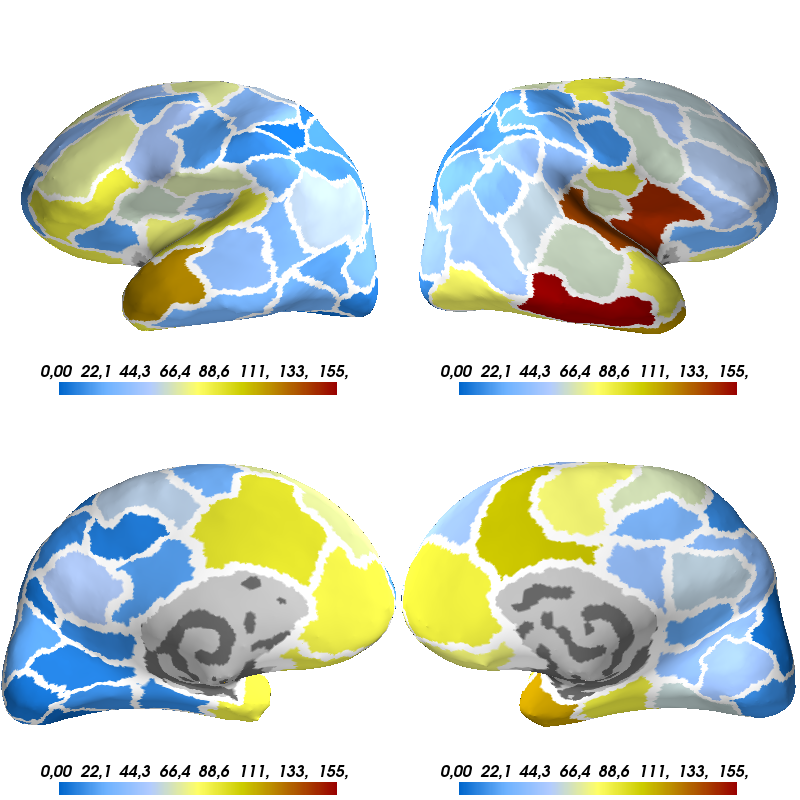

In [74]:
Image('fig1_a.png')

In [84]:
real_sub = '05'
subject_id = "sub-{}".format(real_sub)

subjects_dir = '../seeg_phases/data/SEEG_redux_BIDS/derivatives/'
aparc_file = os.path.join(subjects_dir,
                          subject_id, "label",
                          'lh' + ".parc2011yeo7.annot")
labels_lh, ctab_lh, names_lh = nib.freesurfer.read_annot(aparc_file)


aparc_file = os.path.join(subjects_dir,
                          subject_id, "label",
                          'rh' + ".parc2011yeo7.annot")
labels_rh, ctab_rh, names_rh = nib.freesurfer.read_annot(aparc_file)

names_lh = [n.decode() for n in names_lh]
names_rh = [n.decode() for n in names_rh]

In [85]:
coverage_dict_orig = defaultdict(int)
coverage_dict = defaultdict(int)

for subject in layout.get(target='subject', extension='edf'): 
    subj_num = int(subject.entities['subject'])
    subj_name = df_num_idx.loc[subj_num]['name']
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    montage_filename = os.path.join(subject.dirname,  'sub-{}_montage.tcsv'.format(subject.entities['subject']))
    parc_filename = os.path.join(subject.dirname, 'sub-{}_par-yeo7_mOp.npy'.format(subject.entities['subject']))
    
    if subj_num in {36, 57}:
        continue
    
    if not(os.path.exists(montage_filename)):
        print('Cannot find data for subject {}'.format(subject.entities['subject']))
        continue
        
    montage = pd.read_csv(montage_filename, sep='\t')
    mop = np.load(parc_filename)
    
    ref_mask = create_reference_mask(montage['name'].values)
    ch_names = montage['name'].values
    
    for i in range(mop.shape[0]):
        if subj_ez.loc[ch_names[i]][2] != 0:
            continue
        
        parcel_mop_idx = mop[i,i,0] + 1
        
        if parcel_mop_idx < 92:
            continue

        parc_name = yeo_names[parcel_mop_idx]        
        coverage_dict_orig[parc_name] += 1

    if subject_to_cluster.loc[subj_num]['subject_cluster'] == 4:
        continue
        
    for i in range(mop.shape[0]):
        if subj_ez.loc[ch_names[i]][2] != 0:
            continue
        
        parcel_mop_idx = mop[i,i,0] + 1
        
        if parcel_mop_idx < 92:
            continue

        parc_name = yeo_names[parcel_mop_idx]        
        coverage_dict[parc_name] += 1

In [103]:
brain = Brain(subject_id, "split", "inflated", subjects_dir=subjects_dir, background='white', views=['lat', 'med'])
brain.add_annotation("parc2011yeo7", color='white', borders=True, alpha=0.75)

vtx_data_lh = np.full_like(labels_lh, fill_value=0, dtype=float)

for lbl, name in enumerate(names_lh[1:], start=1):
    vtx_data_lh[labels_lh == lbl] = coverage_dict['LH_' + name]
    
vtx_data_rh = np.full_like(labels_rh, fill_value=0, dtype=float)

for lbl, name in enumerate(names_rh[1:], start=1):
    vtx_data_rh[labels_rh == lbl] = coverage_dict['RH_' + name]

if len(set(vtx_data_lh)) != 1:
    brain.add_data(vtx_data_lh, thresh=1, colormap=ripples_cmap, hemi='lh', colorbar=True)
    
if len(set(vtx_data_rh)) != 1:
    brain.add_data(vtx_data_rh, thresh=1, colormap=ripples_cmap, hemi='rh', colorbar=True)

# bar = mlab.scalarbar(brain._data_dicts['lh'][0]['surfaces'][1])
# bar.label_text_property.color = (0.0, 0.0, 0.0)
# bar.scalar_bar_representation.position2 = .8, 0.09
# bar.scalar_bar_representation.position = 0.5, 0.01

# bar2 = mlab.scalarbar(brain._data_dicts['lh'][0]['surfaces'][1])
# bar2.label_text_property.color = (0.0, 0.0, 0.0)
# bar2.scalar_bar_representation.position2 = .8, 0.09
# bar2.scalar_bar_representation.position = -0.5, 0.01

brain.save_image('fig_1_b.png') 
# brain.save_image('fig_1_b.svg')
# brain.save_image('fig_1_b.pdf')
# brain.show_view("ventral")
# brain.show_view("ventral", row=1, col=1)

colormap sequential: [0.00e+00, 2.95e+02, 5.90e+02] (opaque)
colormap sequential: [0.00e+00, 3.00e+02, 6.01e+02] (opaque)


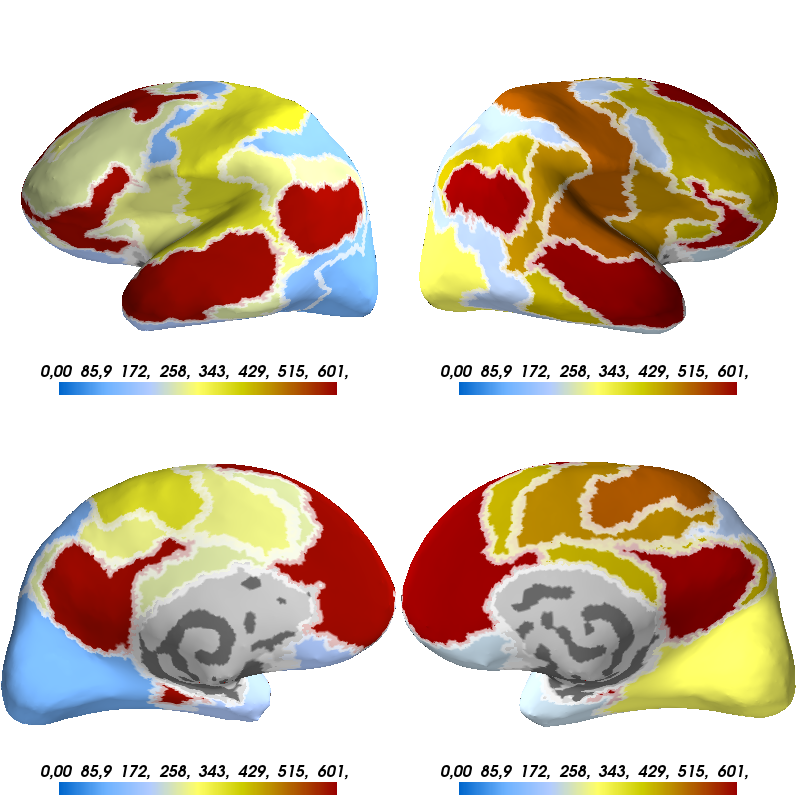

In [104]:
Image('fig_1_b.png')